### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [4]:
dataset.head()

created_date  city_tier first_platform_c first_utm_medium_c  \
0  2021-07-01 00:08:15        1.0           Level0            Level11   
1  2021-07-01 00:16:43        2.0           Level3             Level0   
2  2021-07-01 00:22:20        1.0           Level3             Level0   
3  2021-07-01 00:23:13        1.0           Level1             Level3   
4  2021-07-01 00:28:38        1.0           Level3             Level0   

  first_utm_source_c  total_leads_droppped  referred_lead  app_complete_flag  \
0             Level2                   1.0            0.0                  1   
1             others                   1.0            0.0                  1   
2             Level0                   1.0            0.0                  1   
3             others                   2.0            0.0                  0   
4             Level0                   1.0            0.0                  0   

   assistance_interaction  career_interaction  payment_interaction  \
0                     0.0                 0.0                  0.0   
1                     0.0                 0.0                  0.0   
2                     0.0                 0.0                  0.0   
3                     0.0                 0.0                  0.0   
4                     0.0                 0.0                  0.0   

   social_interaction  syllabus_interaction  
0                 0.0                   0.0  
1                 0.0                   0.0  
2                 0.0                   0.0  
3                 0.0                   0.0  
4                 0.0                   0.0

In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
def create_db_connection(filename):
    conn = None
    try:
        conn = sqlite3.connect(filename)
        print(sqlite3.version)
    except Exception as e:
        print(e)
    finally:
        if conn:
            conn.close()

In [7]:
import sqlite3

In [8]:
create_db_connection("lead_scoring_model_experimentation.db")

2.6.0


In [9]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
mlflow server --backend-store-uri='sqlite:////home/Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="/home/Assignment/mlruns" --port=6006 --host=0.0.0.0

'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\nmlfl

In [10]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [11]:
# setup pycaret 
# Creating the baseline model
Baseline_model_exp01 = setup(data = dataset, target='app_complete_flag', session_id=42,
                            fix_imbalance=False, n_jobs=-1, use_gpu=True,
                            log_experiment=True, log_data=True, verbose=True, log_profile=False, log_plots=True,
                            experiment_name='Baseline_model_exp01')

### 4 : Model Experimentation with pycaret

In [12]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
base_model = compare_models(fold=5,exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [13]:
# create a model which gives the highest accuracy
xgboost = create_model('xgboost', fold = 5)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


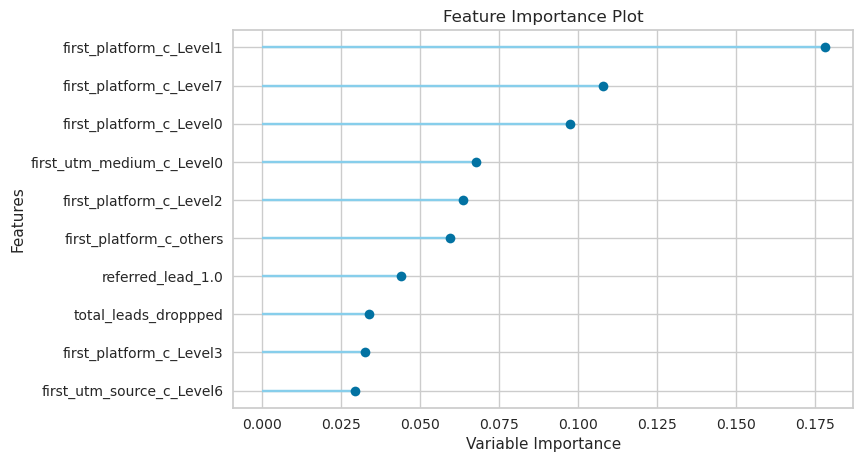

In [14]:
# create feature importance plot
plot_model(xgboost, plot='feature') #feature_all -> to check for all features 

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [15]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
significant_features_lst = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
dataset = dataset[significant_features_lst]

In [16]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 

Baseline_model_exp02 = setup(data = dataset, target='app_complete_flag', session_id=42,
                            fix_imbalance=False, n_jobs=-1, use_gpu=True,
                            log_experiment=True, log_data=True, verbose=True, log_profile=False, log_plots=True,
                            experiment_name='Baseline_model_exp02', normalize = False, transformation = False)

In [17]:
base_model = compare_models(fold=5,exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

In [18]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

lightgbm = create_model('lightgbm', fold = 5)


In [20]:
!pip install optuna

     |████████████████████████████████| 413 kB 1.1 MB/s eta 0:00:01


In [24]:
from optuna.distributions import *
params = {
    'learning_rate': FloatDistribution(0.01, 0.3),
    'num_leaves': IntDistribution(10, 500),
    'min_child_samples': IntDistribution(5, 100),
    'reg_alpha': FloatDistribution(1e-5, 10.0),
    'reg_lambda': FloatDistribution(1e-5, 10.0),
    'max_depth': IntDistribution(3, 15),
    'n_estimators': IntDistribution(50, 1000)
}

In [25]:
tuned_rf_optuna,tuner2 = tune_model(lightgbm, 
                                    custom_grid=params,
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [27]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_rf_optuna)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split',
               learning_rate=0.18180022496999232, max_depth=15,
               min_child_samples=63, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=968, n_jobs=-1, num_leaves=32, objective=None,
               random_state=42, reg_alpha=1.7052495316316785,
               reg_lambda=0.6505252793368653, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [29]:
# Print the final models configuration so that we can use it in the model retraining pipeline
print(tuner2)
print("**"*30)
print(tuned_rf_optuna)



OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         device='gpu',
                                                         importance_type='split',
                                                         learning_rate=0....
                                    'actual_estimator__reg_alpha': FloatDistribution(high=10.0, log=False, low=1e-05, step=None),
                                    'actual_estimator_